**Recommendation System**

Get page links

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.beeradvocate.com/beer/popular/'

# Send an HTTP GET request to the URL.
response = requests.get(url)

print(response)

# Check if the request was successful (status code 200).
if response.status_code == 200:
    # Parse the HTML content of the page using BeautifulSoup.
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the <tbody> element(s) on the page.
    tbody_elements = soup.find_all('table')
    
    # Initialize a list to store the extracted href links.
    href_links = []
    beer = []
    
    # Loop through each <tbody> element.
    for tbody in tbody_elements:
        # Find all <a> elements within the <tbody>.
        a_elements = tbody.find_all('a', href=True)
        
        # Extract and store the href attribute from each <a> element.
        for a in a_elements:
            beer.append(a.text)
            href_links.append(a['href'])

else:
    print('Failed to retrieve the webpage. Status code:', response.status_code)

href_links = [href_links[i] for i in range(0,len(href_links),3)]
beer = [beer[i] for i in range(0,len(beer),3)]

df = pd.DataFrame(list(zip(beer, href_links)),columns =['Beer', 'Link'])
df.to_csv('beer_list.csv')

<Response [200]>


Login and scraping

In [2]:
# The URL of the login page.
login_url = 'https://www.beeradvocate.com/community/login/login'

# Create a session to persist cookies across requests.
session = requests.Session()
# Send a GET request to the login page to obtain any necessary cookies.
response = session.get(login_url)

# Add username and password.
username = ''
password = ''

login_data = {
    'login': username,
    'register': '0',
    'password': password,
    'cookie_check': '1',
    '_xfToken' : '',
    'redirect': "https://www.beeradvocate.com/community/",
}

# Send a POST request to submit the form with the username and password.
login_response = session.post(login_url, data=login_data)

count = 0
beer_list = []
beer_company = []
review_list = []
rating_list = []
pages = ['?view=beer&show=recent&start=0#lists','?view=beer&show=recent&start=20#lists','?view=beer&show=recent&start=40#lists']
for link in href_links:
    count += 1
    for page in pages: 
        # Replace URL of the website we want to scrape.
        url = 'https://www.beeradvocate.com/'+ link + page
        # Send an HTTP GET request to the URL.
        response = session.get(url)
        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            h1_element = soup.find('h1')
            beer_product = h1_element.contents[0].strip()
            company = h1_element.find('span').text.strip()
            outer_divs = soup.find_all('div', id='rating_fullview_content_2')
            for outer_div in outer_divs:
                review_elements = outer_div.find_all('div', style='margin:20px 0px; font-size:11pt; line-height:1.4;')
                if review_elements:
                    for review_element in review_elements:
                        text_content = review_element.get_text()
                        review_list.append(text_content.strip())
                    rating_elements = outer_div.find_all('span', class_='BAscore_norm')
                    for rating_element in rating_elements:
                        text_content = rating_element.get_text()
                        rating_list.append(float(text_content))
                    beer_list.append(beer_product)
                    beer_company.append(company)

df = pd.DataFrame({'Beer': beer_list,'Company':beer_company, 'Rating': rating_list, 'Review':review_list})
# Save the DataFrame to a CSV file
df.to_csv('output2.csv', index=False)  

Word Count

In [3]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
all_text = ""

df = pd.read_csv("output2.csv")

sum_len = 0
beer_dict = {}

df['Review'] = df['Review'].fillna("0")
 

for idx in df.index:
    sum_len += len(df['Review'][idx])
    all_text = all_text + "\n" +"(-" + str(idx) + "-)" + df['Review'][idx]
    if df['Beer'][idx] in beer_dict.keys(): 
        beer_dict[df['Beer'][idx]] += 1
    else: 
        beer_dict[df['Beer'][idx]] = 1

#transform every symbol to be "-"
words = "".join([char.lower() if char.lower() in """abcdefghijklmnopqrstuvwxyz'""" else '-' for char in all_text])

#transform any set of dash to be " "
words = re.sub('-+', ' ', words)

words = words.split()

word_count_dict = {}
for word in words:
    if word not in stop_words:
          if word in word_count_dict.keys():
               word_count_dict[word] += 1
          else:
               word_count_dict[word] = 1

item = list(word_count_dict.items())
df_words = pd.DataFrame(item, columns =['Word', 'Count'])
df_words = df_words.sort_values(by=['Count'],ascending=False)
df_words['Rank'] = [i for i in range(1,len(item)+1,1)] 
df_words.reset_index(inplace = True, drop = True)
df_words.to_csv("Word_Count_Output_Exclude_StopWord.csv", index=False)  
print(df_words.head(30))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Poonnawit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


           Word  Count  Rank
0          beer   4108     1
1          head   3427     2
2         taste   2995     3
3          dark   2142     4
4          good   2138     5
5          malt   2074     6
6          like   1984     7
7         light   1980     8
8         sweet   1807     9
9          nice   1759    10
10       medium   1729    11
11          one   1674    12
12        aroma   1624    13
13  carbonation   1606    14
14       finish   1560    15
15    chocolate   1540    16
16      overall   1498    17
17         hops   1445    18
18         well   1403    19
19       flavor   1397    20
20        white   1390    21
21        notes   1386    22
22       bottle   1351    23
23       lacing   1329    24
24        pours   1308    25
25        glass   1304    26
26       bitter   1280    27
27       coffee   1266    28
28         body   1263    29
29          bit   1230    30


**Lift ratio between each pair of beer attributes**

In [4]:
import numpy as np
from tabulate import tabulate
def lift_ratio(x, y,df,df_words):

    word_counter = 0
    for idx in df.index:
        words = "".join([char.lower() if char.lower() in """abcdefghijklmnopqrstuvwxyz'""" else '-' for char in df['Review'][idx]])
        words = re.sub('-+', ' ', words)
        words = words.split()
        words = set(words)
        if x in words and y in words:
            word_counter += 1
    count_x = df_words.loc[df_words['Word'] == x, 'Count'].values[0]
    count_y = df_words.loc[df_words['Word'] == y, 'Count'].values[0]
    n_sample = len(df.index)
    lift = (word_counter*n_sample)/(count_x *count_y)
    return lift

attributes_list = ['dark', 'malt', 'sweet','light','chocolate','aroma','carbonation','bitter','medium','white']

mtx = [[float(0) for i in range(len(attributes_list))] for i in range(len(attributes_list))]
mtx = np.array(mtx)

df_words = pd.read_csv("Word_Count_Output_Exclude_StopWord.csv") #can comment this line

for i in range(len(attributes_list)):
    for j in range(len(attributes_list)):
        x = attributes_list[i]
        y = attributes_list[j]
        if i > j:
            lift = lift_ratio(x,y,df,df_words)
            mtx[i,j] = lift
        else:
            continue

row, col = mtx.shape

for x in range(row):
    for y in range(col):
        if x-y < 0:
            mtx[x,y] = mtx[y,x]

df_np = pd.DataFrame(mtx, columns=attributes_list)
df_np.to_excel("matrix.xlsx")

rounded_matrix = np.round(mtx, decimals=2)

mtx_present=np.vstack([attributes_list, rounded_matrix])

h=["Similarity"]
h.extend(attributes_list)

mtx_present=np.hstack([np.array(h).reshape(-1,1), mtx_present])

table = tabulate(mtx_present, tablefmt='grid')
print("Lift Ratio table:\n",table)

Lift Ratio table:
 +-------------+------+------+-------+-------+-----------+-------+-------------+--------+--------+-------+
| Similat     | dark | malt | sweet | light | chocolate | aroma | carbonation | bitter | medium | white |
+-------------+------+------+-------+-------+-----------+-------+-------------+--------+--------+-------+
| dark        | 0.0  | 0.6  | 0.62  | 0.54  | 1.06      | 0.71  | 0.8         | 0.64   | 0.65   | 0.32  |
+-------------+------+------+-------+-------+-----------+-------+-------------+--------+--------+-------+
| malt        | 0.6  | 0.0  | 0.74  | 0.7   | 0.52      | 0.86  | 1.07        | 0.8    | 0.95   | 0.93  |
+-------------+------+------+-------+-------+-----------+-------+-------------+--------+--------+-------+
| sweet       | 0.62 | 0.74 | 0.0   | 0.66  | 0.55      | 0.96  | 1.03        | 0.83   | 0.88   | 0.93  |
+-------------+------+------+-------+-------+-----------+-------+-------------+--------+--------+-------+
| light       | 0.54 | 0.7 

MDS Plot

Matplotlib created a temporary cache directory at C:\Users\POONNA~1\AppData\Local\Temp\matplotlib-fayacnow because the default path (C:\Users\Poonnawit\.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
c:\Users\Poonnawit\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


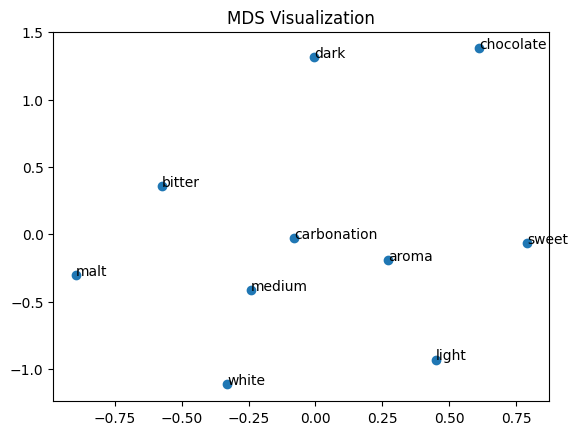

In [5]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

dissim = np.divide(1, mtx, where=mtx!=0)
df_np = pd.DataFrame(dissim)
df_np.to_excel("dissimilarity matrix.xlsx")

dissim[4,9] = 3.5
dissim[9,4] = 3.5

row, col = dissim.shape

df_np = pd.DataFrame(dissim)

#Initialize the MDS model
distance_matrix = dissim
mds = MDS(n_components=2, dissimilarity="precomputed")
#Fit the model to the distance matrix and transform the data to the lower-dimensional space
lower_dimensional_data = mds.fit_transform(distance_matrix)
#Plot the lower-dimensional representation as a scatter plot
plt.scatter(lower_dimensional_data[:, 0], lower_dimensional_data[:, 1])

#Add labels for the data points (optional)
labels = attributes_list
for label, x, y in zip(labels, lower_dimensional_data[:, 0], lower_dimensional_data[:, 1]):
    plt.annotate(label, (x, y))

plt.title('MDS Visualization')
plt.show()

**These following attributes are selected for this recommendation; "medium", "aroma", "carbonation"**

**Find Similarity Score Between ["medium", "aroma", "carbonation"] and each review**

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("output2.csv")
df['Review'] = df['Review'].fillna("0")

with open('selected_attributes.txt') as f:
    lines = f.readlines()
#print(lines)

#Sample DataFrame with 5000++ reviews (assuming you have a similar structure)
text1 = lines[0] #3 selected attributes "medium aroma carbonation"
text2 = df['Review'].tolist()
cos_similarity = []

for review in text2:
    
    documents = [text1, review]
    count_vectorizer = CountVectorizer(stop_words='english')
    sparse_matrix = count_vectorizer.fit_transform(documents)
    doc_term_matrix = sparse_matrix.todense()
    cos_sim = cosine_similarity(np.array(doc_term_matrix[0]), np.array(doc_term_matrix[1]))
    cos_similarity.append(cos_sim[0][0])
df['similarity'] = cos_similarity  
df.to_excel("similarity.xlsx", index=False)  

**Find the sentiment Score**

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create an instance of the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
count = 0
for text in df_words['Word']:
    if count == 1001:
        break
    word = text
    # Get the sentiment score of the word
    word_sentiment_score = analyzer.polarity_scores(word)['compound']
    # Print the sentiment score
    print(f"{count}. The sentiment score of '{word}' is: {word_sentiment_score}")
    count += 1

0. The sentiment score of 'beer' is: 0.0
1. The sentiment score of 'head' is: 0.0
2. The sentiment score of 'taste' is: 0.0
3. The sentiment score of 'dark' is: 0.0
4. The sentiment score of 'good' is: 0.4404
5. The sentiment score of 'malt' is: 0.0
6. The sentiment score of 'like' is: 0.3612
7. The sentiment score of 'light' is: 0.0
8. The sentiment score of 'sweet' is: 0.4588
9. The sentiment score of 'nice' is: 0.4215
10. The sentiment score of 'medium' is: 0.0
11. The sentiment score of 'one' is: 0.0
12. The sentiment score of 'aroma' is: 0.0
13. The sentiment score of 'carbonation' is: 0.0
14. The sentiment score of 'finish' is: 0.0
15. The sentiment score of 'chocolate' is: 0.0
16. The sentiment score of 'overall' is: 0.0
17. The sentiment score of 'hops' is: 0.0
18. The sentiment score of 'well' is: 0.2732
19. The sentiment score of 'flavor' is: 0.0
20. The sentiment score of 'white' is: 0.0
21. The sentiment score of 'notes' is: 0.0
22. The sentiment score of 'bottle' is: 0.0
2

Manually adjust sentiment scores of some words

In [13]:
analyzer = SentimentIntensityAnalyzer()

# Define a custom sentiment lexicon/sentiment score 
custom_lexicon = {
    'bitter': 0, 
    'bitterness': 0,
    'sweetness': 0,
    'sweet':0
}

# Update the VADER lexicon with the custom lexicon
analyzer.lexicon.update(custom_lexicon)

sentiment_score = []

for index, row in df.iterrows():

    text = row['Review']
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    sentiment_score.append(compound_score)

df['sentiment'] = sentiment_score
df.to_excel("sentiment.xlsx", index=False)  

Calculate recommendation score by multiplying similarity with sentiment

In [32]:
df['recommendation'] = df['similarity']*df['sentiment']
df.to_excel("recomendation_score.xlsx", index=False)  

#df.groupby(['Beer','Company']).agg(Median=("recommendation","median"), Average=("recommendation","mean"),Stdev=("recommendation","std"),Min=("recommendation","min"),Max=("recommendation","max")).sort_values('Median', ascending=False).head(10)
df.groupby(['Beer','Company']).agg(Median_Rating=("Rating","median"),Median_Similarity_Score=("similarity","median"), Median_Sentiment_Score=("sentiment","median"), Median_Recommendation_Score=("recommendation","median")).sort_values('Median_Recommendation_Score', ascending=False).head(10)

,,Median_Rating,Median_Similarity_Score,Median_Sentiment_Score,Median_Recommendation_Score
Beer,Company,,,,
Ruthless Rye IPA,Sierra Nevada Brewing Co.,3.935,0.089904,0.89005,0.084414
Maudite,Unibroue,4.230,0.103882,0.89990,0.079350
Smoked Porter,Stone Brewing,4.005,0.078647,0.88495,0.075141
Duet,Alpine Beer Company,4.135,0.091063,0.82935,0.072401
La Fin Du Monde,Unibroue,4.290,0.079902,0.76110,0.071983
A Little Sumpin' Wild,Lagunitas Brewing Company,4.050,0.104869,0.63365,0.071527
Saison Dupont,Brasserie Dupont sprl,4.200,0.075368,0.80825,0.070911
Trois Pistoles,Unibroue,4.345,0.082598,0.92810,0.070466
Nut Brown Ale,Samuel Smith Old Brewery (Tadcaster),4.140,0.080892,0.82460,0.068655


Note: Median_Similarity_Score*Median_Sentiment_Score is **not equal** to Median_Recommendation_Score.

If you want to see the similirity and sentiment for each review, please open recomendation_score.xlsx file

In [33]:
df_top10 = df.groupby(['Beer','Company']).agg(Median_Rating=("Rating","median"), Median_Similarity_Score=("similarity","median"), Median_Sentiment_Score=("sentiment","median"), Median_Recommendation_Score=("recommendation","median")).sort_values('Median_Recommendation_Score', ascending=False).head(3)
df_top10['Rank'] = df_top10['Median_Recommendation_Score'].rank(ascending=False, method='first')
df_top10.head(3)

,,Median_Rating,Median_Similarity_Score,Median_Sentiment_Score,Median_Recommendation_Score,Rank
Beer,Company,,,,,
Ruthless Rye IPA,Sierra Nevada Brewing Co.,3.935,0.089904,0.89005,0.084414,1.0
Maudite,Unibroue,4.230,0.103882,0.89990,0.079350,2.0
Smoked Porter,Stone Brewing,4.005,0.078647,0.88495,0.075141,3.0


**This is where we would recommend beers to our customer!**

Based on the attributes given by our customer, which in this case are 'medium', 'aroma', and 'carbonation', we would recommend the three products listed above, specifically, our first would be Ruthless Rye IPA by Sierra Nevada Brewing Co., second would be Maudite by Unibroue, and third would be Smoked Porter by Stone Brewing.

**Using Spacy_Similarity instead of cosine similarity, then compared the recomendation results**

In [34]:
import spacy
import numpy as np
import pandas as pd
# remove stopwords for spacy as well
# this is an example to compare spacy (uses word embeddings) and basic cosine similarity
# we will calculate the similarity between two documents of unequal length (see below)

nlp = spacy.load('en_core_web_md')

df_spacy = pd.read_csv('output2.csv')  # Load reviews data
df['Review'] = df['Review'].fillna(" ")

text1 = 'medium aroma carbonation' #3 selected attributesdoc1 = nlp(text1)
doc1 = nlp(text1)
text2 = df_spacy['Review'].tolist()
spacy_similarity = []

for review in text2:
    doc2 = nlp(review) 
    spacy_similarity.append(doc1.similarity(doc2))
    
df_spacy['similarity'] = spacy_similarity  
df_spacy.to_excel("similarity_spacy.xlsx", index=False)  

C:\Users\Poonnawit\AppData\Local\Temp\ipykernel_10028\1772000240.py:20: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  spacy_similarity.append(doc1.similarity(doc2))


In [36]:
analyzer = SentimentIntensityAnalyzer()

# Define a custom sentiment lexicon
custom_lexicon = {
    'bitter': 0, 
    'bitterness': 0,
    'sweetness': 0,
    'sweet':0
}

# Update the VADER lexicon with the custom lexicon
analyzer.lexicon.update(custom_lexicon)

sentiment_score = []

for index, row in df_spacy.iterrows():

    text = row['Review']
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    sentiment_score.append(compound_score)
    #print("Compound Score:", compound_score)

df_spacy['sentiment'] = sentiment_score
df_spacy.to_excel("sentiment_spacy.xlsx", index=False)  

In [37]:
df_spacy['recommendation'] = df_spacy['similarity']*df_spacy['sentiment']
df_spacy.to_excel("recommendation_score_spacy.xlsx", index=False)  

df_spacy.groupby(['Beer','Company']).agg(Median_Rating=("Rating","median"), Median_Similarity_Score=("similarity","median"), Median_Sentiment_Score=("sentiment","median"), Median_Recommendation_Score=("recommendation","median")).sort_values('Median_Recommendation_Score', ascending=False).head(10)
#df_spacy.groupby(['Beer','Company']).agg(Median=("recommendation","median"), Average=("recommendation","mean"),Stdev=("recommendation","std"),Min=("recommendation","min"),Max=("recommendation","max")).sort_values('Median', ascending=False).head(10)

,,Median_Rating,Median_Similarity_Score,Median_Sentiment_Score,Median_Recommendation_Score
Beer,Company,,,,
Hunahpu's Imperial Stout,Cigar City Brewing,4.330,0.624732,0.93260,0.612612
Black Note Stout,Bell's Brewery - Eccentric Café & General Store,4.405,0.625843,0.95435,0.602776
Abrasive Ale,Surly Brewing Company,4.460,0.656870,0.93740,0.602300
Trappist Tripel,Brouwerij Westmalle,4.350,0.641132,0.92865,0.592803
Delirium Tremens,Brouwerij Huyghe,4.190,0.622963,0.93570,0.585886
Gueuze 100% Lambic,Brasserie Cantillon,4.420,0.636780,0.91180,0.581705
Oberon,Bell's Brewery - Eccentric Café & General Store,3.920,0.642935,0.88420,0.581333
Darkness,Surly Brewing Company,4.530,0.633477,0.93650,0.580473
Maudite,Unibroue,4.230,0.658945,0.89990,0.579727


In [43]:
df_top10 = df_spacy.groupby(['Beer','Company']).agg(Median_Rating=("Rating","median"), Median_Similarity_Score=("similarity","median"), Median_Sentiment_Score=("sentiment","median"), Median_Recommendation_Score=("recommendation","median")).sort_values('Median_Recommendation_Score', ascending=False).head(3)
df_top10['Rank'] = df_top10['Median_Recommendation_Score'].rank(ascending=False, method='first')
df_top10.head(3)

,,Median_Rating,Median_Similarity_Score,Median_Sentiment_Score,Median_Recommendation_Score,Rank
Beer,Company,,,,,
Hunahpu's Imperial Stout,Cigar City Brewing,4.330,0.624732,0.93260,0.612612,1.0
Black Note Stout,Bell's Brewery - Eccentric Café & General Store,4.405,0.625843,0.95435,0.602776,2.0
Abrasive Ale,Surly Brewing Company,4.460,0.656870,0.93740,0.602300,3.0


This is the new top 10 recommendations that we would give to our customer using word vectors. The top 3 recommended beers are all different from the original recommendation using bag-of-words
. Furthermore, only one of the previous three beers that we recommended still appear among the top 10 ranked beers for our customer using word vectors, which is Maudite by Unibroue.

In [52]:
def has_word_or_similar_word(text, word):
    doc = nlp(text)
    for token in doc:
        # Check if the token is "aroma" or has similarity with "aroma"
        if token.text == word:
            return True
        elif token.similarity(nlp(word)) > 0.7:  # Adjust the similarity threshold as needed
            return True
    return False

def has_exact_word(text, word):
    doc = nlp(text)
    for token in doc:
        # Check if the token is "aroma" or has similarity with "aroma"
        if token.text == word:
            return True
    return False

attributes = ['aroma', 'carbonation', 'medium']
total_count = 0
print("\n================Count using spacy==================\n")
for word in attributes:
    count = 0
    for text in df_spacy[df_spacy['Beer']=="Hunahpu's Imperial Stout"]['Review'].to_list():
        if has_word_or_similar_word(text, word):
            count += 1
    print(f"Number of texts with {word} or similar words using word embeddings: {count}")
    total_count += count
print(f"Number of texts with our attributes or similar words using word embeddings: {total_count}")
print("\n============Count if found exact word==============\n")
total_count = 0
for word in attributes:
    count = 0
    for text in df_spacy[df_spacy['Beer']=="Hunahpu's Imperial Stout"]['Review'].to_list():
        if has_exact_word(text, word):
            count += 1
    print(f"Number of texts with {word} : {count}")
    total_count += count
print(f"Number of texts with our attributes : {total_count}")


================Count using spacy==================



C:\Users\Poonnawit\AppData\Local\Temp\ipykernel_10028\2923862110.py:7: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  elif token.similarity(nlp(word)) > 0.7:  # Adjust the similarity threshold as needed


Number of texts with aroma or similar words using word embeddings: 9
Number of texts with carbonation or similar words using word embeddings: 5
Number of texts with medium or similar words using word embeddings: 6
Number of texts with our attributes or similar words using word embeddings: 20

============Count if found exact word==============

Number of texts with aroma : 2
Number of texts with carbonation : 5
Number of texts with medium : 6
Number of texts with our attributes : 13


From here, we can more objectively observe the difference between the original bag-of-words and our word vectors recommender scores. Specifically, we are measuring how many posts for the beer Hunahpu's Imperial Stout have our three attributes. We can see that from an approach only considering exact word matching, which is used in cosine similarity, there are only 2 reviews that contain the word 'aroma'. This means that from a cosine similarity perspective, this beer will not be a good recommendation to our customer who requests a beer where the aroma is a highlight of the product. However, when moving on to word embeddings and searching for words that are similar to aroma and will be captured through our word vector similarity measure, aroma now appears in 9 reviews. This means that using a word vector approach to calculate similarity, we are able in this case to more accurately deterimine which beers inspire people based on the specific attributes we are searching for. However, it is also worth noting that the same effect was not observed for the word 'carbonation'. This may be due to the fact that carbonation may be a more niche quality that customers will explicity mention when present in the products.

**Compared recommendation score with rating score**

In [58]:
df_1 = pd.read_csv('output2.csv')
highest_rated_beer = df_1.groupby(['Beer','Company']).agg(Median_Rating=("Rating","median")).reset_index().sort_values('Median_Rating', ascending=False).head(3)['Beer'].to_list()
df_spacy[df_spacy['Beer'].isin(highest_rated_beer)].groupby(['Beer','Company']).agg(Median_Rating=("Rating","median"),Median_Recommendation_Score=("recommendation","median")).sort_values('Median_Rating', ascending=False)

['Pliny The Younger', 'Trappist Westvleteren 12 (XII)', 'Bourbon County Brand Stout']


,,Median_Rating,Median_Recommendation_Score
Beer,Company,,
Pliny The Younger,Russian River Brewing Company,4.80,0.489613
Trappist Westvleteren 12 (XII),Brouwerij Westvleteren (Sint-Sixtusabdij van Westvleteren),4.75,0.512576
Bourbon County Brand Stout,Goose Island Beer Co.,4.72,0.554859


By selecting beers purely based on the overall rating of the product, we find that our recommendation becomes much worse. The three beers listed above would be our recommendation ignoring similarity and sentiment, and going purely based on overall ratings. When checking the rankings of these beers based on our similarity and sentiment analysis, we find that the beers are very low ranked for the attributes that our customer wants, with these beers ranked 27, 85, and 129 overall relative to the other beers. This means that relative to other alternatives, these beers do not meet the requirements of the customer, as they have a relatively low match with the attributes that the customer requested. 

**Find the most similar product based on users' reviews**

In [61]:
df_words = pd.read_csv("Word_Count_Output_Exclude_StopWord.csv") #can comment this line
list_of_beer = ["Hunahpu's Imperial Stout", 'Trappist Westvleteren 12 (XII)', 'Pliny The Younger', 'Heady Topper', 'Delirium Tremens',
 'Gueuze 100% Lambic',
 'Oberon',
 'Darkness',
 'Maudite',
 'Guinness Extra Stout (Original)']
list_of_attribute = ['dark', 'malt', 'light', 'sweet']

In [62]:
#x is for beer
#y is for attributes
def lift_ratio_2(x, y,df):
    df_temp = df[df['Beer']==x] 

    word_counter = 0
    for idx in df_temp.index:
        words = "".join([char.lower() if char.lower() in """abcdefghijklmnopqrstuvwxyz'""" else '-' for char in df['Review'][idx]])
        words = re.sub('-+', ' ', words)
        words = words.split()
        words = set(words)
        if y in words:
            word_counter += 1
    
    count_y = 0
    for idx in df.index:
        words = "".join([char.lower() if char.lower() in """abcdefghijklmnopqrstuvwxyz'""" else '-' for char in df['Review'][idx]])
        words = re.sub('-+', ' ', words)
        words = words.split()
        words = set(words)
        if y in words:
            count_y += 1
    
    count_x = len(df_temp)
    n_sample = len(df.index)
    lift = (word_counter*n_sample)/(count_x *count_y)
    return lift

mtx_t = [[float(0) for i in range(len(list_of_beer))] for i in range(len(list_of_attribute))]

mtx_t = np.array(mtx_t).T

for x in range(len(list_of_beer)):
    for y in range(len(list_of_attribute)):
            print(list_of_beer[x],list_of_attribute[y])
            lift = lift_ratio_2(list_of_beer[x],list_of_attribute[y],df)
            mtx_t[x,y] = lift
            print(lift)

df_brand_attribute = pd.DataFrame(mtx_t, columns = list_of_attribute, index = list_of_beer)

Hunahpu's Imperial Stout dark
2.3835287985405262
Hunahpu's Imperial Stout malt
0.7949930458970793
Hunahpu's Imperial Stout light
1.4489226869455005
Hunahpu's Imperial Stout sweet
2.0823315118397088
Trappist Westvleteren 12 (XII) dark
1.6759186864738076
Trappist Westvleteren 12 (XII) malt
1.1179589707927677
Trappist Westvleteren 12 (XII) light
1.0866920152091255
Trappist Westvleteren 12 (XII) sweet
1.3944184231069476
Pliny The Younger dark
0.23521665775070985
Pliny The Younger malt
0.20920869628870506
Pliny The Younger light
0.9151090654392635
Pliny The Younger sweet
0.9393976745141542
Heady Topper dark
0.3724263747719573
Heady Topper malt
0.49687065368567457
Heady Topper light
0.18111533586818757
Heady Topper sweet
0.7436898256570388
Delirium Tremens dark
0.4256301425965226
Delirium Tremens malt
0.567852175640771
Delirium Tremens light
0.8279558211117146
Delirium Tremens sweet
1.69986245864466
Gueuze 100% Lambic dark
0.1787646598905395
Gueuze 100% Lambic malt
0.47699582753824754
Gueuze

**Lift Ratio Between Beer and its attribute** 

In [63]:
rounded_matrix = np.round(mtx_t, decimals=2)

mtx_present=np.vstack([list_of_attribute, rounded_matrix])

h=["Beer"]
h.extend(list_of_beer)

mtx_present=np.hstack([np.array(h).reshape(-1,1), mtx_present])

table = tabulate(mtx_present, tablefmt='grid')
print("Lift Ratio table:\n",table)

Lift Ratio table:
 +---------------------------------+------+------+-------+-------+
| Beer                            | dark | malt | light | sweet |
+---------------------------------+------+------+-------+-------+
| Hunahpu's Imperial Stout        | 2.38 | 0.79 | 1.45  | 2.08  |
+---------------------------------+------+------+-------+-------+
| Trappist Westvleteren 12 (XII)  | 1.68 | 1.12 | 1.09  | 1.39  |
+---------------------------------+------+------+-------+-------+
| Pliny The Younger               | 0.24 | 0.21 | 0.92  | 0.94  |
+---------------------------------+------+------+-------+-------+
| Heady Topper                    | 0.37 | 0.5  | 0.18  | 0.74  |
+---------------------------------+------+------+-------+-------+
| Delirium Tremens                | 0.43 | 0.57 | 0.83  | 1.7   |
+---------------------------------+------+------+-------+-------+
| Gueuze 100% Lambic              | 0.18 | 0.48 | 1.74  | 0.54  |
+---------------------------------+------+------+-------+

**Euclidean Distance between Heady Topper and other brands of beer (word vectors)**

In [64]:
# Choose a target beer (e.g., Beer1)
target_beer = 'Heady Topper'

# Calculate squared errors for each row relative to the target row
target_row = df_brand_attribute.loc[target_beer]
df_brand_attribute['Squared_Error'] = ((df_brand_attribute - target_row) ** 2).sum(axis=1)

# Display the result
print(df_brand_attribute)

                                     dark      malt     light     sweet  \
Hunahpu's Imperial Stout         2.383529  0.794993  1.448923  2.082332   
Trappist Westvleteren 12 (XII)   1.675919  1.117959  1.086692  1.394418   
Pliny The Younger                0.235217  0.209209  0.915109  0.939398   
Heady Topper                     0.372426  0.496871  0.181115  0.743690   
Delirium Tremens                 0.425630  0.567852  0.827956  1.699862   
Gueuze 100% Lambic               0.178765  0.476996  1.738707  0.535457   
Oberon                           0.000000  1.555421  1.700909  0.582018   
Darkness                         3.027466  1.410472  1.261965  1.439400   
Maudite                          1.324183  1.030547  1.126940  1.652644   
Guinness Extra Stout (Original)  1.840224  1.169107  1.534153  0.787436   

                                 Squared_Error  
Hunahpu's Imperial Stout              7.532707  
Trappist Westvleteren 12 (XII)        3.328360  
Pliny The Younger          

In [65]:
print(df_brand_attribute.sort_values('Squared_Error', ascending=True).head(2))

                       dark      malt     light     sweet  Squared_Error
Heady Topper       0.372426  0.496871  0.181115  0.743690       0.000000
Pliny The Younger  0.235217  0.209209  0.915109  0.939398       0.678624


We chose the beer 'Heady Topper', and compared it with other beers on these following attributes:'dark', 'light', 'sweet', and 'malt'. To measure the distance between this beer with other beers, we chose the similarity metric to be sum of squared distances, where we took the distance, for each attribute, between the lift of 'Heady Topper' and the lift of other beers , and then summed the square of these distances. From this we were able to find that the beer "Pliny The Younger' is the most similar with 'Heady Topper'. This procedure could be scaled up to the entire beer set, where we can find the specific lift of a beer for a set of attributes, and then find which other products have the closest match to this beer with the given attributes. This beer could then be recommended to a customer who expresses that he enjoys a specific beer.
This method that we selected to find the most similar beer favors the matching of two beers based on all of the attributes. Different approaches should also be considered if instead of finding the beer that has the least difference over all attributes, we decide to instead choose a beer that is most similar for a given subset of attributes.